## Автоматическое дифференцирование

In [1]:
import torch
from torch import autograd

In [2]:
x = torch.arange(4).type(torch.float)
print(x)

tensor([0., 1., 2., 3.])


## Присоединение градиента к `x`

- Говорит системе, что мы хотим хранить градиент

In [3]:
x.requires_grad

False

In [4]:
x = x.requires_grad_()

In [5]:
x.requires_grad

True

In [6]:
x.grad

## Forward

вычислим 

$$y = 2\mathbf{x}^{\top}\mathbf{x}$$

In [7]:
y = 2 * x.dot(x)

In [8]:
y

tensor(28., grad_fn=<MulBackward0>)

## Backward

In [9]:
y.backward()

## Получение градиента

$y = 2\mathbf{x}^{\top}\mathbf{x}$, значит 

$$\frac{\partial y}{\partial \mathbf x} = 4\mathbf{x}$$

Проверим:

In [10]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [11]:
4 * x == x.grad

tensor([True, True, True, True])

## no_grad

функция no_grad позволяет отключить вычисление градиента для части кода

In [12]:
y = 2 * x.dot(x)
print(y.grad_fn)
with torch.no_grad():
    y = 2 * x.dot(x)
    print(y.grad_fn)

None


In [13]:
y = 2 * x.dot(x)
y.backward()
print(x.grad)
with torch.no_grad():
    y = 2 * x.dot(x)
    y.backward()
    print(x.grad)

tensor([ 0.,  8., 16., 24.])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Гибкий граф

In [14]:
def f(a):
    b = a * 2
    while b.norm().item() < 1000:
        b = b * 2
    if b.sum().item() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [15]:
a = torch.randn(1).requires_grad_()
d = f(a)
d.backward()

In [16]:
d

tensor([-168957.3750], grad_fn=<MulBackward0>)

In [17]:
a

tensor([-0.8250], requires_grad=True)

## Практика

1. Пусть $f(x) = \sin(x) * x$. Постройте график $f(x)$ и $\frac{df(x)}{dx}$ используя пакет autograd'а для расчета производных (т.е. нельзя выводить производную явно)

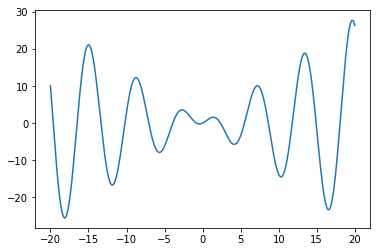

In [97]:
import numpy as np
import matplotlib.pyplot as plt

a = np.linspace(-20,20,1000)
b = np.sin(a)*a + np.cos(a)*a
plt.plot(a,b);

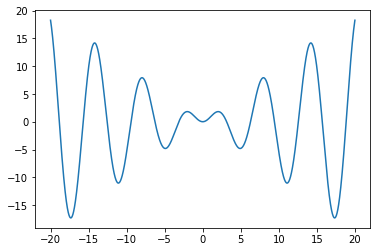

In [95]:
def my_graph(x):
    y = torch.sin(x)*x
    return y

x = torch.linspace(-20,20,10000).requires_grad_()
y = my_graph(x)

plt.plot(x.detach().numpy(),y.detach().numpy());

## Линейная регрессия с нуля

In [102]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import torch
import random

## Генерируем данные

- Случайно генерируем $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$
- Выбираем значения весов (истинные): $\mathbf{w} = [2, -3.4]^\top$ и свободного члена $b = 4.2$
- Генерируем метки по формле $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$
  с шумом $\epsilon$ нормально распределнным с мат ожиданием 0 и дисперсией 1

In [103]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

## Визуализируем данные

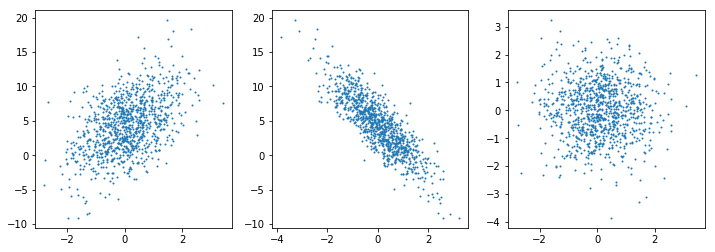

In [104]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(features[:, 0], labels, 1)
plt.subplot(132)
plt.scatter(features[:, 1], labels, 1)
plt.subplot(133)
plt.scatter(features[:, 0], features[:, 1], 1)
plt.show()

## Чтение данных

Итерируемся по датасету и возвращаем случаные `batch_size` примеров.

In [105]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i: min(i + batch_size, num_examples)]
        yield features[j, :], labels[j]

## Выводим маленький батч

In [106]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.3962,  0.4989],
        [-1.4023, -0.1672],
        [ 0.5068,  1.4010],
        [ 1.6272,  0.0867],
        [-0.6641, -0.4058],
        [ 1.1467,  1.9555],
        [-0.1709,  1.0488],
        [ 1.6465, -0.6815],
        [ 0.3743, -0.3591],
        [ 0.0888, -1.5663]]) tensor([ 3.2870,  3.2685,  0.9537,  7.4051,  2.4572, -0.6155,  2.5453, 10.2416,
         5.7769,  9.2966])


### Создаем нашу модель для обучения

In [107]:
w = torch.randn((num_inputs))
b = torch.zeros((1,))

In [108]:
w.requires_grad_()
b.requires_grad_()

tensor([0.], requires_grad=True)

## Практика - реализуйте функции:
- linreg - применение модели линейной регресии
- squared_loss - MSE функция потерь
- sgd - стохастический шаг градиентного спуска по массиву параметров

и допишите код обучения линейной регрессии

In [109]:
def linreg(X, w, b):
    return X.dot(w) + b

### Обучение

In [110]:
def squared_loss(y_hat, y):
    return (y_hat - y)**2

In [122]:
def sgd(params, lr, batch_size):
    for p in range(len(params)):
        p[:] = p - p.grad*lr

In [123]:
lr = 0.01  
num_epochs = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):   
        w = w.detach()
        b = b.detach()
        w.requires_grad_()
        b.requires_grad_()
        
        #
        # ТУТ КОД 
        #
        w, b = sgd([w,b], lr, batch_size)

    train_l = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

AttributeError: 'int' object has no attribute 'grad'

## Оценка качества модели

In [321]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)
print(w)
print(b)

Error in estimating w tensor([ 0.0395, -0.0238], grad_fn=<SubBackward0>)
Error in estimating b tensor([0.0167], grad_fn=<RsubBackward1>)
tensor([ 1.9605, -3.3762], grad_fn=<CopySlices>)
tensor([4.1833], grad_fn=<CopySlices>)


## Линейная регрессия на torch

In [391]:
from torch.utils.data import TensorDataset, DataLoader

In [392]:
num_inputs = 2
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features = torch.randn((num_examples, num_inputs))
labels = torch.mv(features, true_w) + true_b
labels += torch.randn(labels.shape)

In [393]:
batch_size = 10
dataset = TensorDataset(features, labels)
# Randomly reading mini-batches
data_iter = DataLoader(dataset, batch_size, shuffle=True)

# Read a batch to see how it works
for X, y in data_iter:
    print(X, y)
    break

tensor([[-1.2548, -1.0379],
        [ 1.7299, -0.6894],
        [-0.0449,  0.9779],
        [ 1.7366,  2.4321],
        [-2.4948,  1.2552],
        [-0.0520,  1.1157],
        [ 0.6848, -0.6399],
        [ 0.7724, -0.8079],
        [-0.4493,  0.5262],
        [ 0.7553,  0.0686]]) tensor([ 5.5640,  9.8487,  0.2760, -0.5735, -4.9627,  0.6492, 10.2462,  8.5770,
         2.3836,  4.6323])


In [430]:
model = torch.nn.Sequential(torch.nn.Linear(2, 1))

In [425]:
model[0].weight.data = true_w.clone().detach().requires_grad_(True).reshape((1, 2))
model[0].bias.data = torch.tensor([true_b], requires_grad = True)

In [431]:
loss = torch.nn.MSELoss(reduction='mean')

In [433]:
trainer = torch.optim.SGD(model.parameters(), lr=0.001)

In [434]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(model.forward(X).reshape(-1), y)
        l.backward()
        trainer.step()
    l = loss(model.forward(features).reshape(-1), labels)
    print('epoch %d, loss: %f' % (epoch, l.item()))
    print('w', model[0].weight.data)
    print('b', model[0].bias.data)

epoch 1, loss: 23.584707
w tensor([[ 0.3657, -0.1335]])
b tensor([1.2592])
epoch 2, loss: 16.003061
w tensor([[ 0.6636, -0.7542]])
b tensor([1.7906])
epoch 3, loss: 10.963899
w tensor([[ 0.9065, -1.2589]])
b tensor([2.2259])
epoch 4, loss: 7.622250
w tensor([[ 1.1051, -1.6675]])
b tensor([2.5820])
epoch 5, loss: 5.401787
w tensor([[ 1.2667, -1.9989]])
b tensor([2.8741])
epoch 6, loss: 3.923194
w tensor([[ 1.3992, -2.2686]])
b tensor([3.1139])
epoch 7, loss: 2.943227
w tensor([[ 1.5069, -2.4867]])
b tensor([3.3101])
epoch 8, loss: 2.291051
w tensor([[ 1.5955, -2.6641]])
b tensor([3.4707])
epoch 9, loss: 1.857551
w tensor([[ 1.6673, -2.8081]])
b tensor([3.6026])
epoch 10, loss: 1.570167
w tensor([[ 1.7259, -2.9247]])
b tensor([3.7103])
epoch 11, loss: 1.378275
w tensor([[ 1.7738, -3.0200]])
b tensor([3.7988])
epoch 12, loss: 1.251421
w tensor([[ 1.8124, -3.0965]])
b tensor([3.8715])
epoch 13, loss: 1.166722
w tensor([[ 1.8445, -3.1592]])
b tensor([3.9308])
epoch 14, loss: 1.110916
w tens

In [435]:
w = model[0].weight.data
print('Error in estimating w', true_w.reshape(w.shape) - w)
b = model[0].bias.data
print('Error in estimating b', true_b - b)

Error in estimating w tensor([[0.0119, 0.0260]])
Error in estimating b tensor([-0.0006])


In [436]:
model[0].weight.data

tensor([[ 1.9881, -3.4260]])

In [437]:
model[0].bias.data

tensor([4.2006])